In [1]:
# MEJNw2yQ
import sys
sys.path.append("./")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

In [2]:
ds1 = xr.open_dataset("./outputs/t2m_and_ssrd_complete_month_hour_data_2023.nc")
ds2 = xr.open_dataset("./outputs/d2m_complete_month_hour_data_2023.nc")
ds = xr.merge([ds1, ds2])
print("Merged the data variables: ", ds.data_vars)

# https://en.wikipedia.org/wiki/Dew_point#Simple_approximation
ds["relative_humidity"] = 100 - 5 * (ds.t2m - ds.d2m)
ds["relative_humidity"] = ds["relative_humidity"].clip(min=0, max=100)

# Convert the hour to local time based on the longitude
ds = ds.assign_coords(solar_hour=(ds.hour + ds.longitude / 15) % 24)

# Calculate greenhouse heating and cooling degree hours
# As a general guide, it is often recommended that greenhouse relative humidity be maintained between 65 to 75 percent during the night and 80 to 90 percent during the day for healthy plant growth.
max_humidity_daytime = 80
max_humidity_nighttime = 70
ideal_temp_daytime_celsius = 24
ideal_temp_nighttime_celsius = 18
ideal_temp_daytime_kelvin = ideal_temp_daytime_celsius + 273.15
ideal_temp_nighttime_kelvin = ideal_temp_nighttime_celsius + 273.15

print(f"Using ideal temp {ideal_temp_daytime_celsius}C for daytime and {ideal_temp_nighttime_celsius}C for nighttime")

# # Calculate heating degree hours
# Daytime values are only valid for hours [6, 18]
daytime_heating_degree_hours = ideal_temp_daytime_kelvin - ds.t2m
daytime_cooling_degree_hours = ds.t2m - ideal_temp_daytime_kelvin
daytime_humidity_percent_hours = (ds.relative_humidity - max_humidity_daytime).clip(min=0)

# Nighttime values are only valid for hours [18, 6]
nighttime_heating_degree_hours = ideal_temp_nighttime_kelvin - ds.t2m
nighttime_cooling_degree_hours = ds.t2m - ideal_temp_nighttime_kelvin
nighttime_humidity_percent_hours = (ds.relative_humidity - max_humidity_nighttime).clip(min=0)

# Mask the daytime values outside of hours [6, 18]
daytime_heating_degree_hours = daytime_heating_degree_hours.where((ds.solar_hour < 6) | (ds.solar_hour > 18), 0)
daytime_cooling_degree_hours = daytime_cooling_degree_hours.where((ds.solar_hour < 6) | (ds.solar_hour > 18), 0)
daytime_humidity_percent_hours = daytime_humidity_percent_hours.where((ds.solar_hour < 6) | (ds.solar_hour > 18), 0)

# Mask the nighttime values outside of hours [18, 6]
nighttime_heating_degree_hours = nighttime_heating_degree_hours.where((ds.solar_hour > 6) & (ds.solar_hour < 18), 0)
nighttime_cooling_degree_hours = nighttime_cooling_degree_hours.where((ds.solar_hour > 6) & (ds.solar_hour < 18), 0)
nighttime_humidity_percent_hours = nighttime_humidity_percent_hours.where((ds.solar_hour > 6) & (ds.solar_hour < 18), 0)

# Calculate the total heating and cooling degree hours
total_heating_degree_hours = daytime_heating_degree_hours + nighttime_heating_degree_hours
total_cooling_degree_hours = daytime_cooling_degree_hours + nighttime_cooling_degree_hours
total_humidity_percent_hours = daytime_humidity_percent_hours + nighttime_humidity_percent_hours

# Add the heating and cooling degree hours to the dataset
ds['heating_degree_hours'] = total_heating_degree_hours.clip(min=0)
ds['cooling_degree_hours'] = total_cooling_degree_hours.clip(min=0)
ds['humidity_percent_hours'] = total_humidity_percent_hours.clip(min=0)
# Save the dataset
ds.to_netcdf("./outputs/month_hour_hdh_cdh_hph_2023.nc")
ds

Merged the data variables:  Data variables:
    t2m      (latitude, longitude, month, hour) float32 299MB ...
    ssrd     (latitude, longitude, month, hour) float32 299MB ...
    d2m      (latitude, longitude, month, hour) float32 299MB ...
Using ideal temp 24C for daytime and 18C for nighttime


<xarray.Dataset> Size: 2GB
Dimensions:                 (month: 12, hour: 24, latitude: 360, longitude: 720)
Coordinates:
  * month                   (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * hour                    (hour) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * latitude                (latitude) float64 3kB -90.0 -89.5 ... 89.0 89.5
  * longitude               (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    number                  int64 8B 0
    solar_hour              (hour, longitude) float64 138kB 0.0 ... 22.97
Data variables:
    t2m                     (latitude, longitude, month, hour) float32 299MB ...
    ssrd                    (latitude, longitude, month, hour) float32 299MB ...
    d2m                     (latitude, longitude, month, hour) float32 299MB ...
    relative_humidity       (latitude, longitude, month, hour) float32 299MB ...
    heating_degree_hours    (latitude, longitude, month, hour) float32 299MB ...
    cooling_degree_hours    (latitude, longitude, month, hour) float32 299MB ...
    humidity_percent_hours  (latitude, longitude, month, hour) float32 299MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-21T10:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:                 (month: 12, hour: 24, latitude: 360, longitude: 720)
Coordinates:
  * month                   (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * hour                    (hour) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * latitude                (latitude) float64 3kB -90.0 -89.5 ... 89.0 89.5
  * longitude               (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    number                  int64 8B 0
    solar_hour              (hour, longitude) float64 138kB 0.0 ... 22.97
Data variables:
    t2m                     (latitude, longitude, month, hour) float32 299MB ...
    ssrd                    (latitude, longitude, month, hour) float32 299MB ...
    d2m                     (latitude, longitude, month, hour) float32 299MB ...
    relative_humidity       (latitude, longitude, month, hour) float32 299MB ...
    heating_degree_hours    (latitude, longitude, month, hour) float32 299MB ...
    cooling_degree_hours    (latitu

In [2]:
def plot_xarray_map(dataset, variable, cmap='viridis', vmin=None, vmax=None, projection='PlateCarree', figsize=(12, 8), title=None):
  plt.rcParams['font.family'] = 'Helvetica Neue'
  # Create a new figure with the specified projection
  proj = getattr(ccrs, projection)()
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1, projection=proj)

  land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(dataset.longitude, dataset.latitude)
  land_mask = xr.where(~np.isnan(land_mask), True, False)
  masked_data = dataset.copy(deep=True)
  for var in masked_data.data_vars:
    masked_data[var] = masked_data[var].where(land_mask)

  # Set any zeroes to NaN so that they don't get plotted:
  # data_slice = data_slice.where(data_slice != 0, np.nan)
  data_slice = masked_data

  # Determine colormap min/max if not provided
  if vmin is None:
    vmin = data_slice[variable].min().item()
  if vmax is None:
    vmax = data_slice[variable].max().item()
  
  # Create the plot
  im = data_slice[variable].plot(
    ax=ax, transform=ccrs.PlateCarree(), 
    cmap=cmap, vmin=vmin, vmax=vmax,
    add_colorbar=False
  )
  
  # Add a colorbar
  cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                      pad=0.05, shrink=0.8, extend='both')
  
  # Variable specific formatting and labels
  units = {
    't2m': '°C',
    'ssrd': 'J/m²',
    'ssrd_J_m2_year': 'J/m²/year',
    'heating_degree_hours': '°C·h',
    'cooling_degree_hours': '°C·h',
    'humidity_percent_hours': '%·h',
    'total_hvac_cost_no_humidity': '$/year',
    'total_hvac_cost_with_humidity': '$/year',
    'total_hvac_cost': '$/year',
  }
  
  var_names = {
    't2m': 'Temperature at 2m',
    'ssrd': 'Surface Solar Radiation Downwards',
    'ssrd_J_m2_year': 'Surface Solar Radiation Downwards',
    'heating_degree_hours': 'Heating Degree Hours',
    'cooling_degree_hours': 'Cooling Degree Hours',
    'humidity_percent_hours': 'Humidity Percent Hours',
    'total_hvac_cost_no_humidity': 'Total HVAC Cost (no humidity control)',
    'total_hvac_cost_with_humidity': 'Total HVAC Cost',
    'total_hvac_cost': 'Total HVAC Cost'
  }
  
  # Set colorbar label
  cbar.set_label(f"{var_names.get(variable, variable)} ({units.get(variable, '')})")
  
  # Add map features
  ax.coastlines(resolution='110m')
  ax.add_feature(cfeature.BORDERS, linestyle=':')
  ax.add_feature(cfeature.LAKES, alpha=0.5)

  # Mask any values that are over an ocean:
  ax.add_feature(cfeature.OCEAN, alpha=1)
  
  # Add gridlines
  gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
  gl.top_labels = False
  gl.right_labels = False
  ax.set_title(title)
  
  plt.tight_layout()
  return fig

<xarray.DataArray 't2m' (latitude: 299, longitude: 720)> Size: 861kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(299, 720), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 2kB -59.5 -59.0 -58.5 -58.0 ... 88.5 89.0 89.5
  * longitude  (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
    number     int64 8B 0


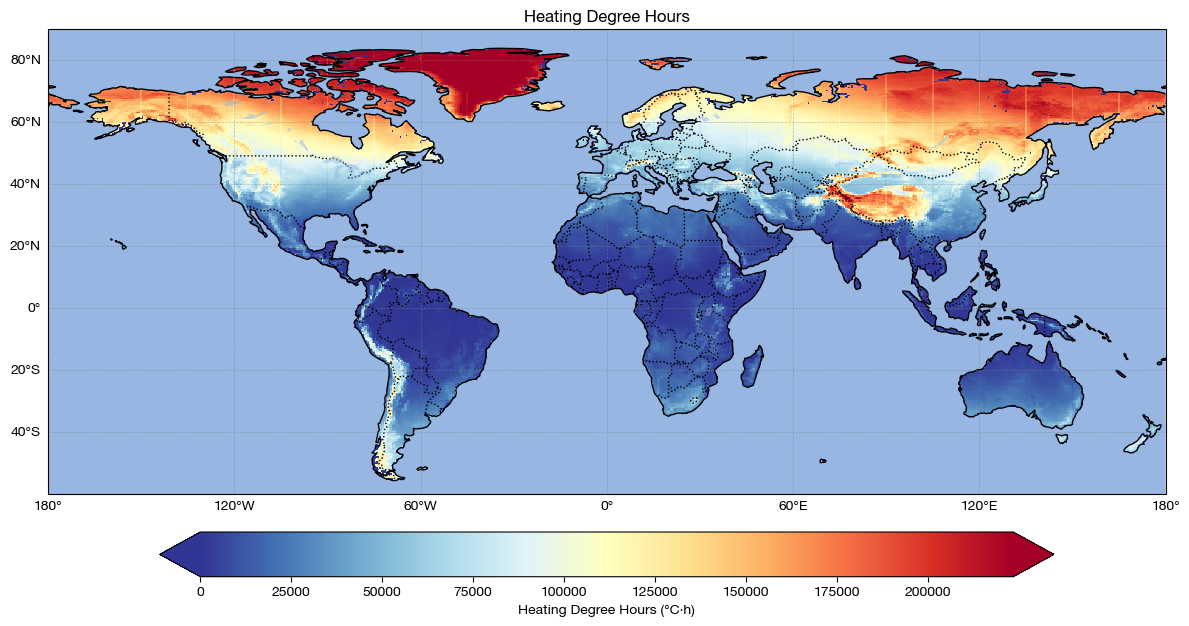

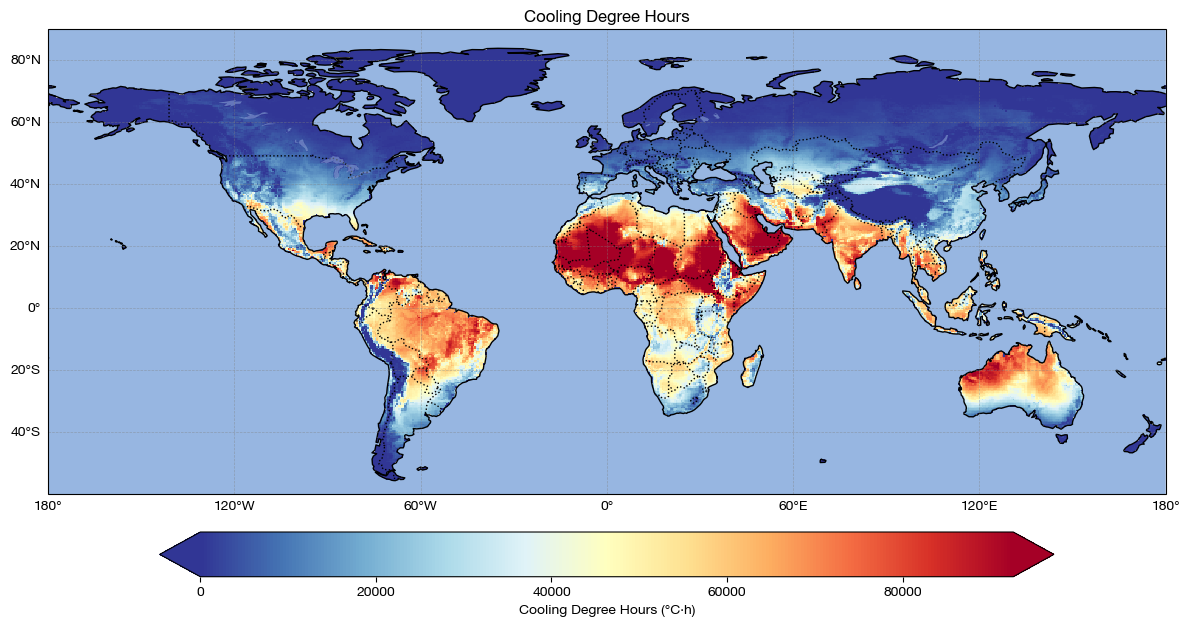

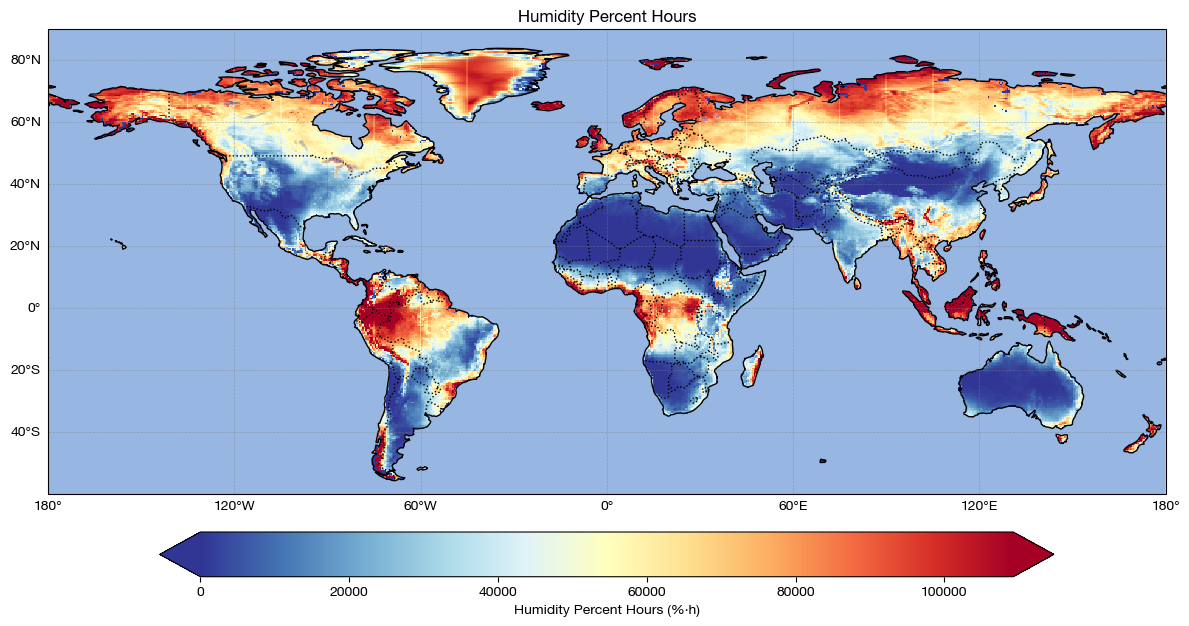

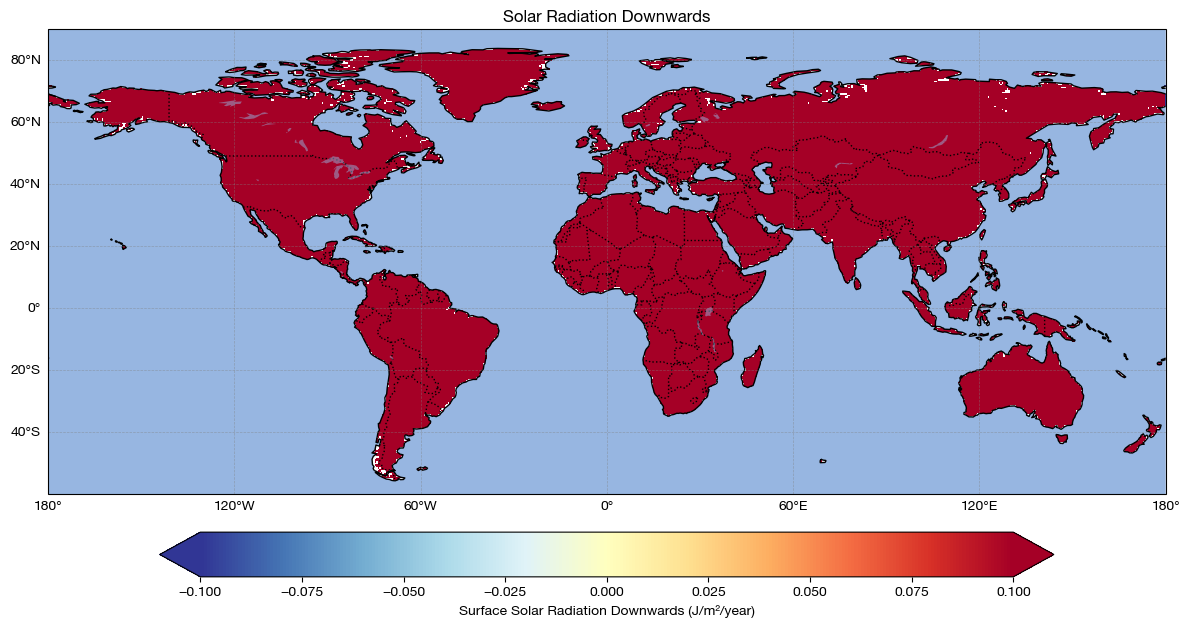

In [ ]:
# Cut off the map so that it only shows latitudes > -60:
ds = xr.open_dataset("./outputs/month_hour_hdh_cdh_hph_2023.nc")
ds_subset = ds.where(ds.latitude > -60, drop=True)

# Add up all months and hours to get the total heating degree hours:
hdh = ds_subset['heating_degree_hours'].sum(dim=['month', 'hour'])
cdh = ds_subset['cooling_degree_hours'].sum(dim=['month', 'hour'])
hph = ds_subset['humidity_percent_hours'].sum(dim=['month', 'hour'])
t2m = ds_subset['t2m'].mean(dim=['month', 'hour'])
print(t2m)

# For SSRD, we only want the last hour in each day, and get rid of hour dimension:
ssrd = ds_subset['ssrd'].isel(hour=23).mean(dim=['month']).squeeze() * 365
ds_total = xr.merge([hdh, cdh, hph, t2m, ssrd])
# We've summed an average day for each month, so we need to multiply by 30 to get a month's worth:
passive_solar_free_heating_factor = 0.3
passive_solar_extra_cooling_factor = 0.3
ds_total['heating_degree_hours'] *= 30 * (1 - passive_solar_free_heating_factor)
ds_total['cooling_degree_hours'] *= 30 * (1 + passive_solar_extra_cooling_factor)
ds_total['humidity_percent_hours'] *= 30
ds_total['ssrd_J_m2_year'] = ds_total['ssrd']
# ds_total.to_netcdf("./outputs/annual_hdh_cdh_hph_2023.nc", mode="w")

value_hdh_99th_percentile = np.percentile(ds_total['heating_degree_hours'], 99)
value_cdh_99th_percentile = np.percentile(ds_total['cooling_degree_hours'], 99)
value_hph_99th_percentile = np.percentile(ds_total['humidity_percent_hours'], 99)
value_ssrd_99th_percentile = np.percentile(ds_total['ssrd_J_m2_year'], 99)

# fig = plot_xarray_map(
#   ds_total, variable='heating_degree_hours', title='Heating Degree Hours', cmap='RdYlBu_r', vmax=value_hdh_99th_percentile)
# plt.savefig('./outputs/hdh_total_map.png', dpi=300)
# plt.show()

# fig = plot_xarray_map(
#   ds_total, variable='cooling_degree_hours', title='Cooling Degree Hours', cmap='RdYlBu_r', vmax=value_cdh_99th_percentile)
# plt.savefig('./outputs/cdh_total_map.png', dpi=300)
# plt.show()

# fig = plot_xarray_map(
#   ds_total, variable='humidity_percent_hours', title='Humidity Percent Hours', cmap='RdYlBu_r', vmax=value_hph_99th_percentile)
# plt.savefig('./outputs/hph_total_map.png', dpi=300)
# plt.show()

# Plot SSRD
fig = plot_xarray_map(ds_total, variable='ssrd_J_m2_year', title='Solar Radiation Downwards', cmap='RdYlBu_r')
plt.savefig('./outputs/ssrd_total_map.png', dpi=300)
plt.show()


In [9]:
# Get only the last hour of each day (23):
# ssrd_last_hour = ds_subset.sel(hour=23)['ssrd']
# avg_ssrd_per_day = ssrd_last_hour.mean().values
avg_ssrd_per_day = ssrd.mean().values / 365

# Print average SSRD:
joule_to_kwh = 2.78E-07
print("Average SSRD (J/m²/year): ", avg_ssrd_per_day * 365)
print("Average SSRD (kWh/m²/year): ", avg_ssrd_per_day * 365 * joule_to_kwh)

Average SSRD (J/m²/year):  5544324000.0
Average SSRD (kWh/m²/year):  1541.322


50th percentile $/year: 0.0
90th percentile $/year: 94279.0859375
95th percentile $/year: 108821.8671875
99th percentile $/year: 130717.7265625


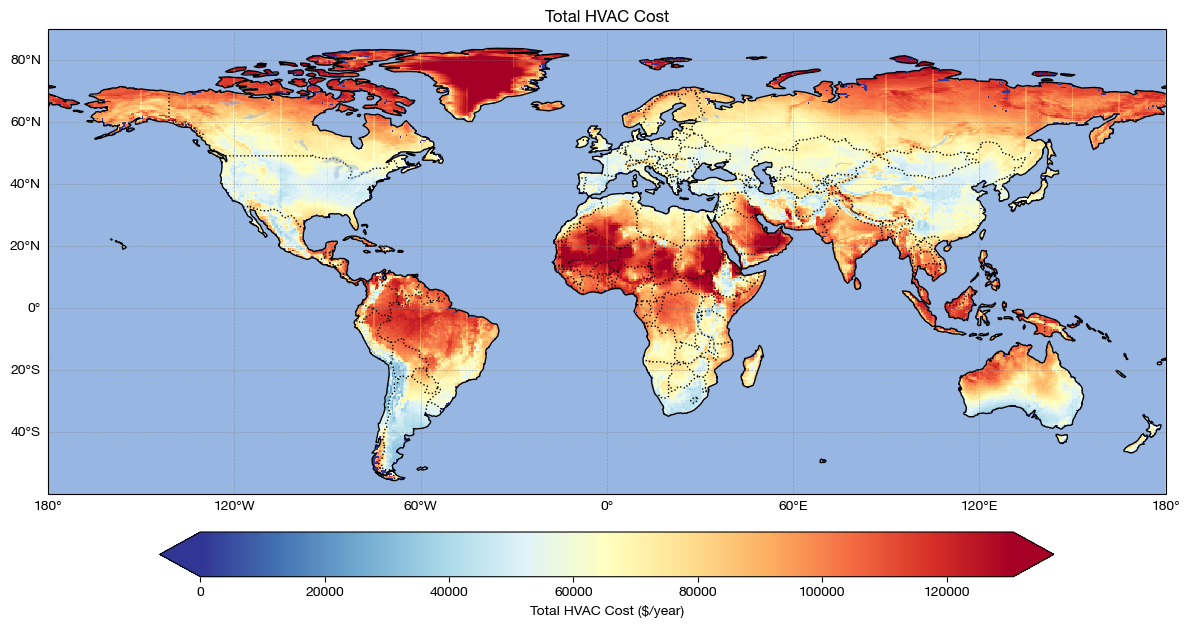

In [18]:
ds_total = xr.open_dataset("./outputs/annual_hdh_cdh_hph_2023.nc")

heating_degree_hour_cost_factor = 0.41 # $/degree-hour
cooling_degree_hour_cost_factor = 1.23 # $/degree-hour
humidity_percent_hour_cost_factor = 0.38 # $/percent-hour

heating_degree_hours_cost = ds_total['heating_degree_hours'] * heating_degree_hour_cost_factor
cooling_degree_hours_cost = ds_total['cooling_degree_hours'] * cooling_degree_hour_cost_factor
humidity_percent_hours_cost = ds_total['humidity_percent_hours'] * humidity_percent_hour_cost_factor  
total_cost = heating_degree_hours_cost + cooling_degree_hours_cost + humidity_percent_hours_cost

cost_50th_percentile = np.percentile(total_cost, 50)
cost_90th_percentile = np.percentile(total_cost, 90)
cost_95th_percentile = np.percentile(total_cost, 95)
cost_99th_percentile = np.percentile(total_cost, 99)
print(f"50th percentile $/year: {cost_50th_percentile}")
print(f"90th percentile $/year: {cost_90th_percentile}")
print(f"95th percentile $/year: {cost_95th_percentile}")
print(f"99th percentile $/year: {cost_99th_percentile}")

ds_total['total_hvac_cost'] = total_cost

plot_xarray_map(
  ds_total,
  variable='total_hvac_cost',
  title='Total HVAC Cost',
  cmap='RdYlBu_r',
  vmax=cost_99th_percentile
)
plt.savefig('./outputs/total_hvac_cost_map_clipped.png', dpi=300)
plt.show()

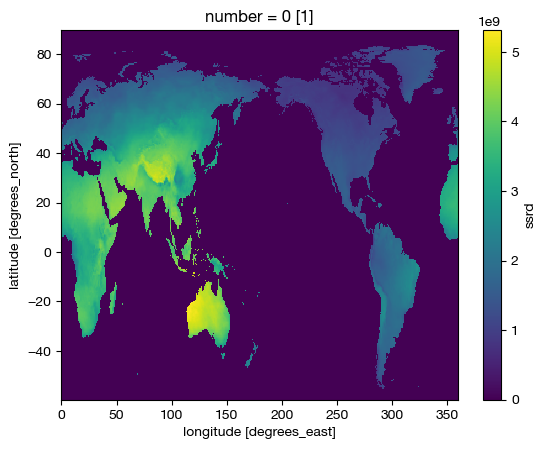

In [ ]:
# Plot SSRD
ds_total['ssrd'].plot()
# plt.savefig('./outputs/ssrd_total_map.png', dpi=300)
# plt.show()
# 2-5e9 J/m2/year
# The average solar flux at Earth's surface is approximately 3.15 x 10^10 J/m²/year.


Average SSRD (J/m²): 7303360.5


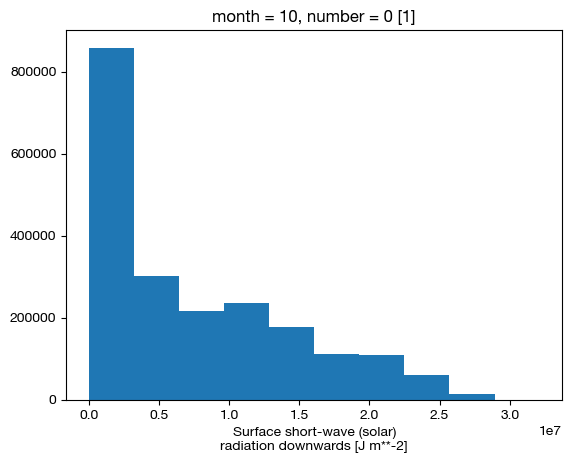

In [36]:
# Debug SSRD
# tmp_ds = xr.open_dataset("./data/era5/t2m_and_ssrd/2023_01.nc")
# print("Opened")
tmp_ds = xr.open_dataset("./data/era5/t2m_and_ssrd/month_hour_averages_2023_10.nc")
tmp_ds.ssrd.plot()
print(f"Average SSRD (J/m²): {tmp_ds.ssrd.mean().values}")
plt.show()